# Tarea 7. Estimación del riesgo sistemático ($\beta$).

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6e/Separation_theorem_of_MPT.svg/2000px-Separation_theorem_of_MPT.svg.png" width="400px" height="400px" />

**Resumen.**
> En esta tarea aplicarás la técnica aprendida en clase para la estimación del coeficiente de riesgo sistemático $\beta$, el cual es primordial en el modelo de valoración de activos en equilibrio CAPM.

**Criterio de revisión.**
> Se te calificará de acuerdo a los resultados finales que reportes, basados en tu análisis.

**Antes de comenzar.**
> Por favor, copiar y pegar este archivo en otra ubicación. Antes de comenzar, nombrarlo *Tarea7_ApellidoNombre*, sin acentos y sin espacios; por ejemplo, en mi caso el archivo se llamaría *Tarea7_JimenezEsteban*. Resolver todos los puntos en dicho archivo y subir en este espacio.

In [46]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as opt
from scipy.optimize import minimize

## 1. Selección de activos (10 puntos)

Seleccionar cinco (5) activos de su preferencia y enunciarlos en una celda en formato Markdown.

#### Las empresas seleccionadas son las siguientes:

1. Tesla Inc - TSLA
2. Ford Motor Company - F
3. Netflix Inc - NFLX
4. Facebok Inc - FB
5. The Procter & Gamble Company - PG


## 2. Descarga de datos (10 puntos)

Descargar los precios mensuales ajustados en el cierre para el índice S&P 500 (^GSPC) y para los activos seleccionados en los últimos cinco años.

1. Graficar los precios (5 puntos).
2. Graficar los rendimientos (5 puntos).

In [2]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None, freq='m'):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.YahooDailyReader(symbols=tickers, start=start_date, end=end_date, interval=freq).read()['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

In [3]:
# Importar datos de AAPL, MSFT, y ^GSPC
names = ['TSLA', 'F', 'NFLX', 'FB', 'PG','^GSPC']
start = '2015-07-01'
end = '2020-07-01'

In [4]:
# Obtener precios mensuales
closes = get_adj_closes(tickers=names, start_date=start, end_date=end)
closes.head(10)

Symbols,TSLA,F,NFLX,FB,PG,^GSPC
Date,,,,,,
2015-07-01,266.149994,11.494650,114.309998,94.010002,65.677582,2103.840088
2015-08-01,249.059998,10.860409,115.029999,89.730003,61.009575,1972.180054
2015-09-01,248.399994,10.625504,103.260002,89.900002,62.105988,1920.030029
2015-10-01,206.929993,11.596441,108.379997,101.970001,65.939049,2079.360107
2015-11-01,230.259995,11.334781,123.330002,104.239998,65.190147,2080.409912
2015-12-01,240.009995,11.144945,114.379997,104.660004,69.170921,2043.939941
2016-01-01,191.199997,9.444334,91.839996,112.209999,71.156937,1940.239990
2016-02-01,191.929993,10.017759,93.410004,106.919998,70.546928,1932.229980
2016-03-01,229.770004,10.810531,102.230003,114.099998,72.321800,2059.739990


In [5]:
# Obtener rendimientos mensuales
ret = closes.pct_change().dropna()
ret.head(10)

Symbols,TSLA,F,NFLX,FB,PG,^GSPC
Date,,,,,,
2015-08-01,-0.064212,-0.055177,0.006299,-0.045527,-0.071075,-0.062581
2015-09-01,-0.002650,-0.021629,-0.102321,0.001895,0.017971,-0.026443
2015-10-01,-0.166948,0.091378,0.049584,0.134260,0.061718,0.082983
2015-11-01,0.112743,-0.022564,0.137941,0.022261,-0.011357,0.000505
2015-12-01,0.042343,-0.016748,-0.072570,0.004029,0.061064,-0.017530
2016-01-01,-0.203367,-0.152590,-0.197062,0.072138,0.028712,-0.050735
2016-02-01,0.003818,0.060716,0.017095,-0.047144,-0.008573,-0.004128
2016-03-01,0.197155,0.079137,0.094422,0.067153,0.025159,0.065991
2016-04-01,0.047830,0.004444,-0.119339,0.030500,-0.026607,0.002699


In [6]:
ret_m = ret.mean()
ret_m

Symbols
TSLA     0.036599
F       -0.007254
NFLX     0.029575
FB       0.018106
PG       0.011061
^GSPC    0.007547
dtype: float64

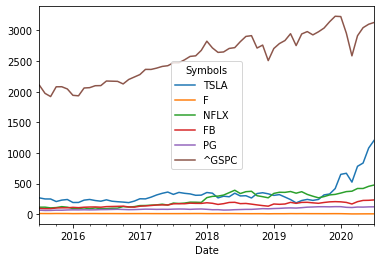

In [7]:
closes.plot()

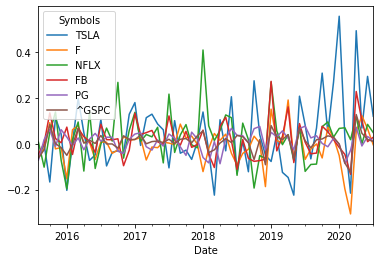

In [8]:
ret.plot()

## 3. Calculando los coeficientes $\beta$ (50 puntos)

Usando los datos de rendimientos mensuales calculados en el punto anterior:

1. Estime el valor del coeficiente de riesgo sistemático $\beta$ para cada uno de los activos seleccionados, con el método visto en clase (5 puntos por cada activo).
2. Compare su estimación de $\beta$ con el valor reportado en Yahoo! Finance mediante el error relativo: 
$$e_{relativo}=\frac{\beta_{estimado}-\beta_{Yahoo!}}{\beta_{Yahoo!}}.$$
Concluya de acuerdo al valor del error relativo obtenido (5 puntos por cada activo).

In [9]:
# Obtener matriz de covarianza
cov = ret.cov()
cov

Symbols,TSLA,F,NFLX,FB,PG,^GSPC
Symbols,,,,,,
TSLA,0.024720,0.001750,0.003091,0.003039,0.000817,0.002214
F,0.001750,0.006393,0.001447,0.003169,0.001029,0.002320
NFLX,0.003091,0.001447,0.011758,0.004108,-0.000859,0.001717
FB,0.003039,0.003169,0.004108,0.006038,0.000753,0.002163
PG,0.000817,0.001029,-0.000859,0.000753,0.001699,0.000719
^GSPC,0.002214,0.002320,0.001717,0.002163,0.000719,0.001819


In [21]:
# Beta de Tesla
beta_T = cov.loc['TSLA', '^GSPC'] / cov.loc['^GSPC', '^GSPC']
beta_Tr = 1.17
beta_T, beta_Tr

(1.2176494049088127, 1.17)

In [23]:
# Beta de Ford
beta_F = cov.loc['F', '^GSPC'] / cov.loc['^GSPC', '^GSPC']
beta_Fr = 1.30
beta_F, beta_Fr

(1.275725597433242, 1.3)

In [24]:
# Beta de Netflix
beta_N = cov.loc['NFLX', '^GSPC'] / cov.loc['^GSPC', '^GSPC']
beta_Nr = 0.96
beta_N, beta_Nr

(0.9443847471758864, 0.96)

In [25]:
# Beta de Facebook
beta_FB = cov.loc['FB', '^GSPC'] / cov.loc['^GSPC', '^GSPC']
beta_FBr = 1.20
beta_F, beta_FBr

(1.275725597433242, 1.2)

In [26]:
# Beta de P&G
beta_PG = cov.loc['PG', '^GSPC'] / cov.loc['^GSPC', '^GSPC']
beta_PGr = 0.40
beta_PG, beta_PGr

(0.39524789708159513, 0.4)

In [27]:
#Error relativo de Tesla
e_T = abs((beta_T - beta_Tr ) / beta_Tr)
e_T

0.040725987101549364

In [28]:
#Error relativo de Ford
e_F = abs((beta_F - beta_Fr ) / beta_Fr)
e_F

0.018672617359044658

In [29]:
#Error relativo de Netflix
e_N = abs((beta_N - beta_Nr ) / beta_Nr)
e_N

0.016265888358451646

In [30]:
#Error relativo de Facebook
e_FB = abs((beta_FB - beta_FBr ) / beta_FBr)
e_FB

0.008751409749003791

In [31]:
#Error relativo de P&G
e_PG = abs((beta_PG - beta_PGr ) / beta_PGr)
e_PG

0.01188025729601222

In [37]:
tabla = pd.DataFrame(columns = ['Beta estimada','Beta real', 'Error relativo'], index = ['TSLA', 'F', 'NFLX', 'FB', 'PG'])
tabla.index.name = 'Empresa'
tabla['Beta estimada'] = np.array([beta_T , beta_F , beta_N , beta_FB , beta_PG])
tabla['Beta real'] = np.array([beta_Tr , beta_Fr , beta_Nr , beta_FBr , beta_PGr])
tabla['Error relativo'] = np.array([e_T, e_F, e_N, e_FB, e_PG])

tabla.round(4)

,Beta estimada,Beta real,Error relativo
Empresa,,,
TSLA,1.2176,1.17,0.0407
F,1.2757,1.30,0.0187
NFLX,0.9444,0.96,0.0163
FB,1.1895,1.20,0.0088
PG,0.3952,0.40,0.0119


### Conclusiones: 

Un error relativo de la beta que supera el valor de 0.1 se considera como una inexactitud no aceptable. En el caso de los datos recopilados esto no sucede en ningún valor, incluso tienen, salvo el de TSLA, una diferencia de  magnitud lo que significa que son muy similares. Esto quiere decir que hicimos un buen trabajo y que se puede trabajar con ellos.


## 4. Gráfico y conclusiones (30 puntos)

1. Grafique cada uno de los activos en el espacio de $E[r]$ (eje $y$) vs. $\beta$ (eje $x$) (10 puntos).
2. Ajuste una línea recta a los puntos obtenidos. Dar la ecuación (10 puntos).
3. De la ecuación obtenida, identifique el valor de la tasa libre de riesgo $r_f$, y el valor del rendimiento esperado del portafolio de mercado $E[r_M]$. Compare este último con el rendimiento esperado del índice S&P500 (10 puntos).

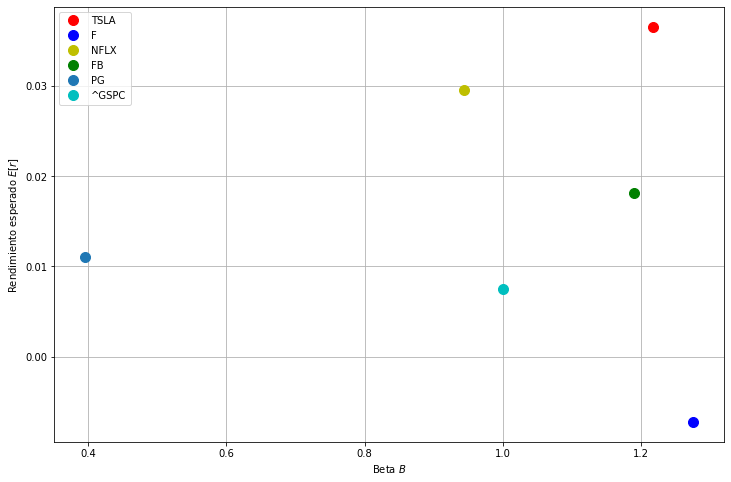

In [44]:
# Gráfica de E[r] contra beta
plt.figure(figsize=(12,8))
plt.plot(beta_T, ret_m['TSLA'], 'or', ms=10, label='TSLA')
plt.plot(beta_F, ret_m['F'], 'ob', ms=10, label='F')
plt.plot(beta_N, ret_m['NFLX'], 'oy', ms=10, label='NFLX')
plt.plot(beta_FB, ret_m['FB'],'og', ms=10, label='FB')
plt.plot(beta_PG, ret_m['PG'],'o', ms=10, label='PG')
plt.plot(1, ret_m['^GSPC'],'oc', ms=10, label='^GSPC')
plt.xlabel('Beta $B$')
plt.ylabel('Rendimiento esperado $E[r]$')
plt.grid()
plt.legend(loc='best')

In [45]:
# Media y Volatilidad
ret_summary = pd.DataFrame(data={'Mean':ret.mean(),'Vol':ret.std()}, index=ret.columns)
ret_summary

,Mean,Vol
Symbols,,
TSLA,0.036599,0.157225
F,-0.007254,0.079958
NFLX,0.029575,0.108435
FB,0.018106,0.077705
PG,0.011061,0.041219
^GSPC,0.007547,0.042645


In [47]:
def objetivo(beta, vol, mean_ret):
    recta=beta[0]+ beta[1]*vol
    return ((mean_ret-recta)**2).sum()
beta0=[0,1]

In [48]:
beta_ini=[0,0]
solucion=minimize(fun=objetivo, x0=beta0, args=(tabla['Beta estimada'],ret_summary['Mean']))
solucion

      fun: 0.0011642765400299612
 hess_inv: array([[ 1.05005601, -0.94635025],
       [-0.94635025,  0.94260248]])
      jac: array([1.51558197e-07, 1.23545760e-08])
  message: 'Optimization terminated successfully.'
     nfev: 28
      nit: 6
     njev: 7
   status: 0
  success: True
        x: array([0.01635001, 0.00126152])

In [49]:
beta_ini=[0,0]
solucion=minimize(fun=objetivo, x0=beta0, args=(tabla['Beta estimada'],ret_summary['Mean']))
solucion

      fun: 0.0011642765400299612
 hess_inv: array([[ 1.05005601, -0.94635025],
       [-0.94635025,  0.94260248]])
      jac: array([1.51558197e-07, 1.23545760e-08])
  message: 'Optimization terminated successfully.'
     nfev: 28
      nit: 6
     njev: 7
   status: 0
  success: True
        x: array([0.01635001, 0.00126152])

In [50]:
beta=solucion.x
beta

array([0.01635001, 0.00126152])

In [59]:
# Ecuación
print(beta[0], '+' ,beta[1],'x')

0.016350011815861046 + 0.001261518387764979 x


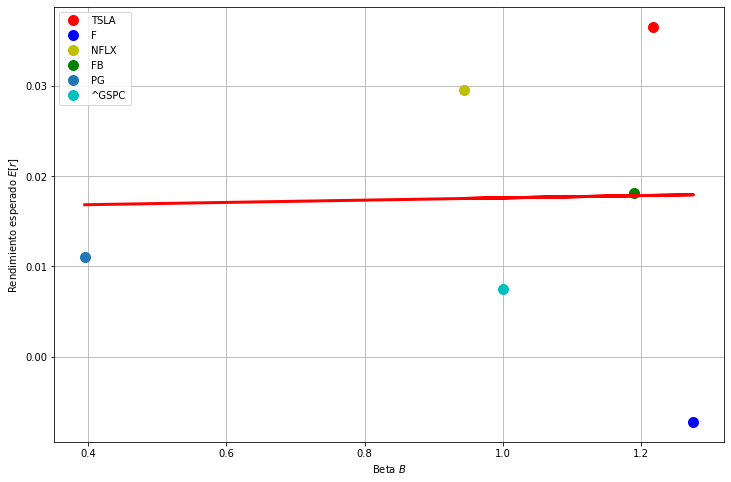

In [51]:
# Gráfica de E[r] contra beta
plt.figure(figsize=(12,8))
plt.plot(beta_T, ret_m['TSLA'], 'or', ms=10, label='TSLA')
plt.plot(beta_F, ret_m['F'], 'ob', ms=10, label='F')
plt.plot(beta_N, ret_m['NFLX'], 'oy', ms=10, label='NFLX')
plt.plot(beta_FB, ret_m['FB'],'og', ms=10, label='FB')
plt.plot(beta_PG, ret_m['PG'],'o', ms=10, label='PG')
plt.plot(1, ret_m['^GSPC'],'oc', ms=10, label='^GSPC')
plt.xlabel('Beta $B$')
plt.ylabel('Rendimiento esperado $E[r]$')
plt.grid()
plt.legend(loc='best')
# Recta ajustada
x_points = tabla['Beta estimada']
y_points = ret_summary['Mean']
plt.plot(x_points, beta[0] + beta[1]*x_points,'r', lw=3, label='Recta ajustada')

In [54]:
# Rendimiento esperado del portafolio del mercado
Erm= beta[0]+beta[1]
Erm

0.017611530203626026

In [55]:
# Rendimiento esperado del portafolio del S&P500
Ersp = ret_m.loc['^GSPC']
Ersp

0.007547211496699498

In [58]:
ER = Erm - Ersp
Erper = Erm / Ersp *100
ER, Erper

(0.010064318706926527, 233.3514863248207)

### Conclusiones

El rendimiento esperado del portafolio del mercado es de 0.017611, mientras que el del S&P se queda en 0.007547. Esto nos da una diferencia de 0.010064 a favor del portafolio del mercado, llevandose con creces el rendimiento del S&P. Nos da como conclusión que **invertir en el protafolio de mercado es mucho más conveniente**, pues **su rendimiento más que duplica al de S&P, siendo 233.3514% de su total.** 

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>